<a href="https://colab.research.google.com/github/Yutong-Lu/CHL5230FinalProject/blob/main/YutongLu_Datathon5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import torch as t
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

import warnings

In [3]:
# Load the CSV file into a DataFrame
file_path = 'mhealth.csv'
df = pd.read_csv(file_path)

df.head()

,alx,aly,alz,glx,gly,glz,arx,ary,arz,grx,gry,grz,Activity,subject
0,2.1849,-9.6967,0.63077,0.103900,-0.84053,-0.68762,-8.6499,-4.5781,0.187760,-0.44902,-1.0103,0.034483,0,subject1
1,2.3876,-9.5080,0.68389,0.085343,-0.83865,-0.68369,-8.6275,-4.3198,0.023595,-0.44902,-1.0103,0.034483,0,subject1
2,2.4086,-9.5674,0.68113,0.085343,-0.83865,-0.68369,-8.5055,-4.2772,0.275720,-0.44902,-1.0103,0.034483,0,subject1
3,2.1814,-9.4301,0.55031,0.085343,-0.83865,-0.68369,-8.6279,-4.3163,0.367520,-0.45686,-1.0082,0.025862,0,subject1
4,2.4173,-9.3889,0.71098,0.085343,-0.83865,-0.68369,-8.7008,-4.1459,0.407290,-0.45686,-1.0082,0.025862,0,subject1


In [4]:
df.shape

(999999, 14)

In [5]:
# no missing value
df.isnull().sum()

alx         0
aly         0
alz         0
glx         0
gly         0
glz         0
arx         0
ary         0
arz         0
grx         0
gry         0
grz         0
Activity    0
subject     0
dtype: int64

In [6]:
# Check the number of sequence for each person
df['subject'].value_counts()

subject1    161280
subject2    130561
subject8    129024
subject3    122112
subject5    119808
subject4    116736
subject7    104448
subject6     98304
subject9     17726
Name: subject, dtype: int64

In [7]:
# Check activity frequency
df['Activity'].value_counts()

0     720946
1      27648
2      25406
3      24576
4      24576
9      24576
10     24576
11     24576
5      24576
7      23809
8      23501
6      22990
12      8243
Name: Activity, dtype: int64

In [8]:
data_crosstab = pd.crosstab(df['subject'], df['Activity'], margins = False)
print(data_crosstab)

Activity      0     1     2     3     4     5     6     7     8     9     10  \
subject                                                                        
subject1  126106  3072  3072  3072  3072  3072  3072  3072  3379  3072  3072   
subject2   95029  3072  3072  3072  3072  3072  3174  3328  3430  3072  3072   
subject3   86732  3072  3072  3072  3072  3072  3226  3379  3175  3072  3072   
subject4   81408  3072  3072  3072  3072  3072  3328  3277  3123  3072  3072   
subject5   85861  3072  3072  3072  3072  3072  2765  2868  2714  3072  3072   
subject6   66099  3072  3072  3072  3072  3072  2202  2099  2304  3072  3072   
subject7   70195  3072  3072  3072  3072  3072  3072  2765  2816  3072  3072   
subject8   95692  3072  3072  3072  3072  3072  2151  3021  2560  3072  3072   
subject9   13824  3072   830     0     0     0     0     0     0     0     0   

Activity    11    12  
subject               
subject1  3072  1075  
subject2  3072  1024  
subject3  3072  1024  
subj

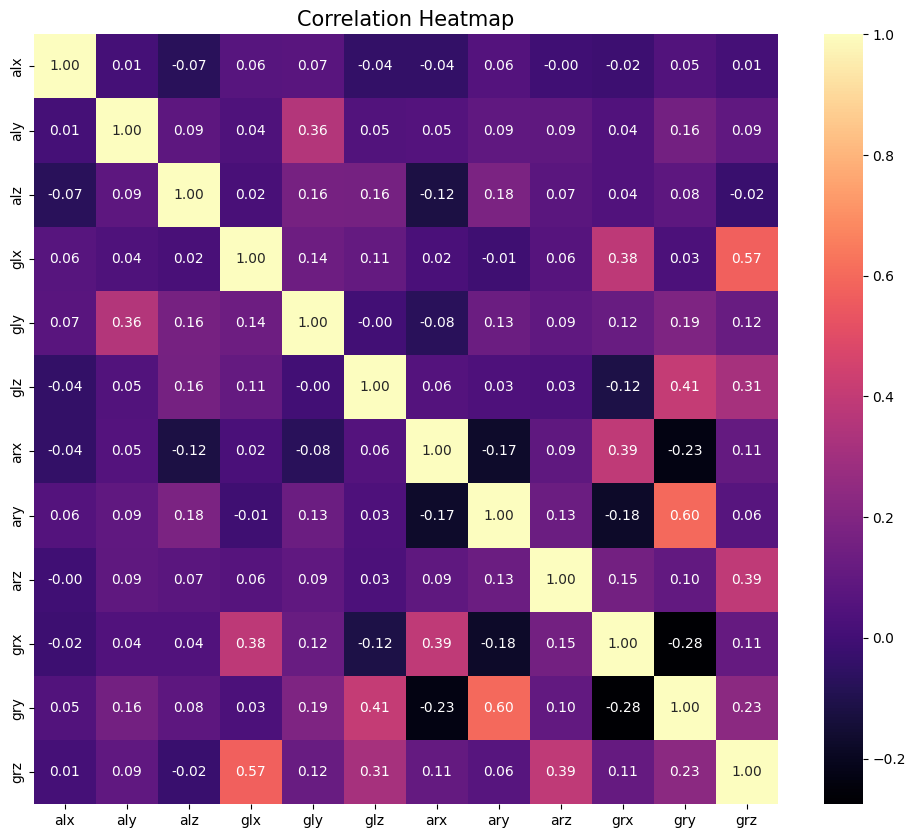

In [9]:
# For the correlation heatmap, we'll use only numerical columns.

numerical_features = [
    col for col in df.select_dtypes(include=[np.number]).columns
    if col != 'Activity'
]

# Recalculate the correlation matrix without the '_id' columns
correlation_matrix = df[numerical_features].corr()

# Plot the updated correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='magma')
plt.title('Correlation Heatmap', fontsize=15)
plt.show()

In [10]:
from sklearn.model_selection import train_test_split

# Grouping by 'patient_nbr' and creating a list of dataframes, one per group
grouped = df.groupby('subject')
grouped_dfs = [group for _, group in grouped]

# Splitting the groups into training and test sets with an 80:20 ratio
train_groups, test_groups = train_test_split(grouped_dfs, test_size=0.2, random_state=42)

# Reassembling the training and test datasets from the groups
train_df = pd.concat(train_groups)
test_df = pd.concat(test_groups)

# Displaying the shape of the training and test sets
train_df_shape = train_df.shape
test_df_shape = test_df.shape

train_df_shape, test_df_shape

((740414, 14), (259585, 14))

In [11]:
# Identifying numerical columns (excluding 'patient_nbr' and 'readmitted')
numerical_columns = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_columns.remove('Activity')

# Initializing the StandardScaler
scaler = StandardScaler()

# Fitting the scaler to the training data and transforming both training and test data
train_df[numerical_columns] = scaler.fit_transform(train_df[numerical_columns])
test_df[numerical_columns] = scaler.transform(test_df[numerical_columns])

# Checking the first few rows of the normalized training data
train_df.head()

,alx,aly,alz,glx,gly,glz,arx,ary,arz,grx,gry,grz,Activity,subject
650497,-0.552567,0.055747,-0.810059,0.578981,-0.800349,0.501238,-1.814050,0.678081,-0.577362,-0.556227,2.101663,0.012934,0,subject6
650498,-1.531305,0.104970,-0.369903,0.693642,-0.720535,0.533071,-1.213665,0.758524,-0.989728,-0.556227,2.101663,0.012934,0,subject6
650499,-1.634742,0.162005,-0.446628,0.693642,-0.720535,0.533071,-0.665509,0.721946,-1.405218,-0.770194,1.968628,-0.202877,0,subject6
650500,-1.058302,0.102992,-0.337213,0.693642,-0.720535,0.533071,-0.339275,0.722070,-1.640731,-0.770194,1.968628,-0.202877,0,subject6
650501,-1.119704,0.167596,-0.387926,0.601930,-0.704601,0.653347,-0.163938,0.695687,-1.610853,-0.770194,1.968628,-0.202877,0,subject6


Address class imbalance (not used)

In [12]:
# Checking the class distribution in the 'Activity' column of the training set
class_distribution = train_df.groupby('subject').apply(lambda x : x.iloc[-1]['Activity']).value_counts()
class_distribution

0    6
2    1
dtype: int64

In [13]:
# Checking subjects in training set
train_df['subject'].value_counts()

subject1    161280
subject3    122112
subject5    119808
subject4    116736
subject7    104448
subject6     98304
subject9     17726
Name: subject, dtype: int64

In [14]:
from sklearn.utils import resample

# Grouping the original training data by 'subject'
grouped_by_subject = train_df.groupby('subject')

# Creating separate lists for each class
groups_class_0 = [grouped_by_subject.get_group(subject) for subject in grouped_by_subject.groups if grouped_by_subject.get_group(subject)['Activity'].iloc[-1] == 0]
groups_class_2 = [grouped_by_subject.get_group(subject) for subject in grouped_by_subject.groups if grouped_by_subject.get_group(subject)['Activity'].iloc[-1] == 2]


In [15]:
# Importing tqdm for progress bar visualization in loops
from tqdm import tqdm

# Oversampling the minority groups (class 1 and class 2)

# Similarly, oversampling records in groups_class_2 to match the number in groups_class_0
oversampled_groups_class_2 = resample(groups_class_2, replace=True, n_samples=len(groups_class_0), random_state=42)

# Combining the oversampled minority class groups with the majority class group
# This results in a balanced dataset with an equal number of records for each class
balanced_groups = oversampled_groups_class_2 + groups_class_0

# Preparing to create a modified copy of the balanced dataset
balanced_groups_copy = []
i = 0
# Looping over each group in the balanced dataset
for i, group in tqdm(enumerate(balanced_groups)):
    # Assigning a new, unique identifier to each record in the group
    group.loc[:,'subject'] = i
    # Incrementing the identifier for the next group
    i += 1
    # Appending a copy of the modified group to the balanced_groups_copy list
    balanced_groups_copy.append(group.copy())

0it [00:00, ?it/s]<ipython-input-15-f8b96843aa71>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group.loc[:,'subject'] = i
<ipython-input-15-f8b96843aa71>:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  group.loc[:,'subject'] = i
12it [00:00, 175.37it/s]


In [16]:
# Reassembling the balanced training dataset
train_df_balanced = pd.concat(balanced_groups_copy, ignore_index=True)

# Checking the new class distribution in the balanced dataset
print(train_df_balanced.groupby('subject').apply(lambda x : x.iloc[-1]['Activity']).value_counts())

2.0    6
0.0    6
dtype: int64


Create sequence for training set

In [18]:
def create_sequences(data, sequence_length=100):
    sequences = []
    output = []
    for i in range(0, len(data) - sequence_length + 1, sequence_length):
        sequence = data[i:i + sequence_length]
        # Assuming 'Activity' is the target variable and is the same for the entire sequence
        label = sequence['Activity'].iloc[0]
        sequences.append(sequence[numerical_features].values)
        output.append(label)

    return np.array(sequences), np.array(output)

# Creating sequences for training and test data
X_train, y_train = create_sequences(train_df, sequence_length=100)
X_test, y_test = create_sequences(test_df, sequence_length=100)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7404, 100, 12), (7404,), (2595, 100, 12), (2595,))

In [ ]:
# Hyperparameters
input_size = X_train.shape[2]
hidden_size = 256  # Number of hidden units in RNN
num_classes = 13  # For 0-12 class classification
epochs = 100
learning_rate = 0.001
batch_size = 512
landa = 0.001  # Regularization term (lambda)

# Data preparation
train_dataset = TensorDataset(t.tensor(X_train, dtype=t.float32), t.tensor(y_train, dtype=t.long))
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(t.tensor(X_test, dtype=t.float32), t.tensor(y_test, dtype=t.long))
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# RNN layers and additional fully connected layer
rnn_layer1 = nn.LSTM(input_size, hidden_size, batch_first=True)
dropout1 = nn.Dropout(0.5)  # Add dropout between RNN layers
# rnn_layer2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
# dropout2 = nn.Dropout(0.5)  # Add dropout between RNN layers
fc_layer1 = nn.Linear(hidden_size, hidden_size)  # Additional fully connected layer
fc_layer2 = nn.Linear(hidden_size, num_classes)  # Final output layer

# Dropout layer
dropout_fc = nn.Dropout(0.2)  # Add dropout between fully connected layers

# Activation function
relu = nn.ReLU()

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
# optimizer = Adam(list(rnn_layer1.parameters()) + list(rnn_layer2.parameters()) + list(fc_layer1.parameters()) + list(fc_layer2.parameters()), lr=learning_rate)
optimizer = Adam(list(rnn_layer1.parameters()) + list(fc_layer1.parameters()) + list(fc_layer2.parameters()), lr=learning_rate)

# Lists to store accuracies and losses
train_accuracy_list = []
validation_accuracy_list = []
train_loss_list = []

# Training loop
for epoch in range(epochs):
    if epoch % 10 == 0:
        learning_rate *= 0.9  # Learning rate scheduling

    per_epoch_loss_list = []
    for X, Y in train_data_loader:
        # Forward pass through layers
        out, _ = rnn_layer1(X)
        out = dropout1(out)  # Apply dropout between RNN layers
        # out, _ = rnn_layer2(out)
        # out = dropout2(out)  # Apply dropout between RNN layers
        out = out[:, -1, :]  # Get the last output of the sequence
        out = relu(fc_layer1(out))  # Apply activation function after first fully connected layer
        out = dropout_fc(out)  # Apply dropout between fully connected layers
        out = fc_layer2(out)

        # Regularization
        # l2_term = sum([(w ** 2).sum() for w in list(rnn_layer1.parameters()) + list(rnn_layer2.parameters()) + list(fc_layer1.parameters()) + list(fc_layer2.parameters())])
        # loss = loss_fn(out, Y) + landa * l2_term
        loss = loss_fn(out, Y)

        per_epoch_loss_list.append(loss.item())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluation on training and validation data
    rnn_layer1.eval()
    # rnn_layer2.eval()
    fc_layer1.eval()
    fc_layer2.eval()

    with t.no_grad():
        # Training data
        train_correct, train_total = 0, 0
        for X, Y in train_data_loader:
            out, _ = rnn_layer1(X)
            out = dropout1(out)  # Apply dropout between RNN layers
            # out, _ = rnn_layer2(out)
            # out = dropout2(out)  # Apply dropout between RNN layers
            out = out[:, -1, :]
            out = relu(fc_layer1(out))
            out = dropout_fc(out)  # Apply dropout between fully connected layers
            out = fc_layer2(out)
            _, predicted = t.max(out.data, 1)
            train_total += Y.size(0)
            train_correct += (predicted == Y).sum().item()
        train_accuracy = 100 * train_correct / train_total

        # Validation data
        validation_correct, validation_total = 0, 0
        for X, Y in test_data_loader:
            out, _ = rnn_layer1(X)
            out = dropout1(out)  # Apply dropout between RNN layers
            # out, _ = rnn_layer2(out)
            # out = dropout2(out)  # Apply dropout between RNN layers
            out = out[:, -1, :]
            out = relu(fc_layer1(out))
            out = dropout_fc(out)  # Apply dropout between fully connected layers
            out = fc_layer2(out)
            _, predicted = t.max(out.data, 1)
            validation_total += Y.size(0)
            validation_correct += (predicted == Y).sum().item()
        validation_accuracy = 100 * validation_correct / validation_total

        # Print accuracy for the current epoch
        print(f'Epoch {epoch}/{epochs} ---> Train Accuracy: {train_accuracy}%, Validation Accuracy: {validation_accuracy}%')

        # Append accuracy values to lists
        train_accuracy_list.append(train_accuracy)
        validation_accuracy_list.append(validation_accuracy)

    # Calculate and append the average loss for the epoch
    train_loss_list.append(sum(per_epoch_loss_list) / len(per_epoch_loss_list))

    # Set the model back to train mode
    rnn_layer1.train()
    # rnn_layer2.train()
    fc_layer1.train()
    fc_layer2.train()

KeyboardInterrupt: ignored

In [ ]:
# Plot training and validation accuracy over epochs
plt.plot([i for i in range(len(train_accuracy_list))], train_accuracy_list, label="Train")
plt.plot([i for i in range(len(validation_accuracy_list))], validation_accuracy_list, label="Validation")
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

lr = 0.01

In [ ]:
# Hyperparameters
input_size = X_train.shape[2]
hidden_size = 256  # Number of hidden units in RNN
num_classes = 13  # For 0-12 class classification
epochs = 100
learning_rate = 0.01
batch_size = 512
landa = 0.001  # Regularization term (lambda)

# Data preparation
train_dataset = TensorDataset(t.tensor(X_train, dtype=t.float32), t.tensor(y_train, dtype=t.long))
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(t.tensor(X_test, dtype=t.float32), t.tensor(y_test, dtype=t.long))
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# RNN layers and additional fully connected layer
rnn_layer1 = nn.LSTM(input_size, hidden_size, batch_first=True)
dropout1 = nn.Dropout(0.5)  # Add dropout between RNN layers
# rnn_layer2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
# dropout2 = nn.Dropout(0.5)  # Add dropout between RNN layers
fc_layer1 = nn.Linear(hidden_size, hidden_size)  # Additional fully connected layer
fc_layer2 = nn.Linear(hidden_size, num_classes)  # Final output layer

# Dropout layer
dropout_fc = nn.Dropout(0.2)  # Add dropout between fully connected layers

# Activation function
relu = nn.ReLU()

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
# optimizer = Adam(list(rnn_layer1.parameters()) + list(rnn_layer2.parameters()) + list(fc_layer1.parameters()) + list(fc_layer2.parameters()), lr=learning_rate)
optimizer = Adam(list(rnn_layer1.parameters()) + list(fc_layer1.parameters()) + list(fc_layer2.parameters()), lr=learning_rate)

# Lists to store accuracies and losses
train_accuracy_list = []
validation_accuracy_list = []
train_loss_list = []

# Training loop
for epoch in range(epochs):
    if epoch % 10 == 0:
        learning_rate *= 0.9  # Learning rate scheduling

    per_epoch_loss_list = []
    for X, Y in train_data_loader:
        # Forward pass through layers
        out, _ = rnn_layer1(X)
        out = dropout1(out)  # Apply dropout between RNN layers
        # out, _ = rnn_layer2(out)
        # out = dropout2(out)  # Apply dropout between RNN layers
        out = out[:, -1, :]  # Get the last output of the sequence
        out = relu(fc_layer1(out))  # Apply activation function after first fully connected layer
        out = dropout_fc(out)  # Apply dropout between fully connected layers
        out = fc_layer2(out)

        # Regularization
        # l2_term = sum([(w ** 2).sum() for w in list(rnn_layer1.parameters()) + list(rnn_layer2.parameters()) + list(fc_layer1.parameters()) + list(fc_layer2.parameters())])
        # loss = loss_fn(out, Y) + landa * l2_term
        loss = loss_fn(out, Y)

        per_epoch_loss_list.append(loss.item())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluation on training and validation data
    rnn_layer1.eval()
    # rnn_layer2.eval()
    fc_layer1.eval()
    fc_layer2.eval()

    with t.no_grad():
        # Training data
        train_correct, train_total = 0, 0
        for X, Y in train_data_loader:
            out, _ = rnn_layer1(X)
            out = dropout1(out)  # Apply dropout between RNN layers
            # out, _ = rnn_layer2(out)
            # out = dropout2(out)  # Apply dropout between RNN layers
            out = out[:, -1, :]
            out = relu(fc_layer1(out))
            out = dropout_fc(out)  # Apply dropout between fully connected layers
            out = fc_layer2(out)
            _, predicted = t.max(out.data, 1)
            train_total += Y.size(0)
            train_correct += (predicted == Y).sum().item()
        train_accuracy = 100 * train_correct / train_total

        # Validation data
        validation_correct, validation_total = 0, 0
        for X, Y in test_data_loader:
            out, _ = rnn_layer1(X)
            out = dropout1(out)  # Apply dropout between RNN layers
            # out, _ = rnn_layer2(out)
            # out = dropout2(out)  # Apply dropout between RNN layers
            out = out[:, -1, :]
            out = relu(fc_layer1(out))
            out = dropout_fc(out)  # Apply dropout between fully connected layers
            out = fc_layer2(out)
            _, predicted = t.max(out.data, 1)
            validation_total += Y.size(0)
            validation_correct += (predicted == Y).sum().item()
        validation_accuracy = 100 * validation_correct / validation_total

        # Print accuracy for the current epoch
        print(f'Epoch {epoch}/{epochs} ---> Train Accuracy: {train_accuracy}%, Validation Accuracy: {validation_accuracy}%')

        # Append accuracy values to lists
        train_accuracy_list.append(train_accuracy)
        validation_accuracy_list.append(validation_accuracy)

    # Calculate and append the average loss for the epoch
    train_loss_list.append(sum(per_epoch_loss_list) / len(per_epoch_loss_list))

    # Set the model back to train mode
    rnn_layer1.train()
    # rnn_layer2.train()
    fc_layer1.train()
    fc_layer2.train()

Epoch 0/100 ---> Train Accuracy: 73.0686115613182%, Validation Accuracy: 73.71868978805395%
Epoch 1/100 ---> Train Accuracy: 72.784981091302%, Validation Accuracy: 73.68015414258188%
Epoch 2/100 ---> Train Accuracy: 72.70394381415451%, Validation Accuracy: 73.02504816955684%
Epoch 3/100 ---> Train Accuracy: 74.89195029713669%, Validation Accuracy: 72.98651252408477%
Epoch 4/100 ---> Train Accuracy: 74.66234467855213%, Validation Accuracy: 73.94990366088632%
Epoch 5/100 ---> Train Accuracy: 74.83792544570503%, Validation Accuracy: 74.83622350674374%
Epoch 6/100 ---> Train Accuracy: 75.0%, Validation Accuracy: 74.373795761079%
Epoch 7/100 ---> Train Accuracy: 74.74338195569962%, Validation Accuracy: 74.45086705202313%
Epoch 8/100 ---> Train Accuracy: 76.63425175580767%, Validation Accuracy: 74.79768786127168%
Epoch 9/100 ---> Train Accuracy: 76.95840086439762%, Validation Accuracy: 73.68015414258188%
Epoch 10/100 ---> Train Accuracy: 77.40410588870881%, Validation Accuracy: 74.4894026974

In [1]:
# Plot training and validation accuracy over epochs
plt.plot([i for i in range(len(train_accuracy_list))], train_accuracy_list, label="Train")
plt.plot([i for i in range(len(validation_accuracy_list))], validation_accuracy_list, label="Validation")
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

NameError: ignored

lr = 0.05

In [19]:
# Hyperparameters
input_size = X_train.shape[2]
hidden_size = 256  # Number of hidden units in RNN
num_classes = 13  # For 0-12 class classification
epochs = 100
learning_rate = 0.05
batch_size = 512
landa = 0.001  # Regularization term (lambda)

# Data preparation
train_dataset = TensorDataset(t.tensor(X_train, dtype=t.float32), t.tensor(y_train, dtype=t.long))
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(t.tensor(X_test, dtype=t.float32), t.tensor(y_test, dtype=t.long))
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# RNN layers and additional fully connected layer
rnn_layer1 = nn.LSTM(input_size, hidden_size, batch_first=True)
dropout1 = nn.Dropout(0.5)  # Add dropout between RNN layers
# rnn_layer2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
# dropout2 = nn.Dropout(0.5)  # Add dropout between RNN layers
fc_layer1 = nn.Linear(hidden_size, hidden_size)  # Additional fully connected layer
fc_layer2 = nn.Linear(hidden_size, num_classes)  # Final output layer

# Dropout layer
dropout_fc = nn.Dropout(0.2)  # Add dropout between fully connected layers

# Activation function
relu = nn.ReLU()

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
# optimizer = Adam(list(rnn_layer1.parameters()) + list(rnn_layer2.parameters()) + list(fc_layer1.parameters()) + list(fc_layer2.parameters()), lr=learning_rate)
optimizer = Adam(list(rnn_layer1.parameters()) + list(fc_layer1.parameters()) + list(fc_layer2.parameters()), lr=learning_rate)

# Lists to store accuracies and losses
train_accuracy_list = []
validation_accuracy_list = []
train_loss_list = []

# Training loop
for epoch in range(epochs):
    if epoch % 10 == 0:
        learning_rate *= 0.9  # Learning rate scheduling

    per_epoch_loss_list = []
    for X, Y in train_data_loader:
        # Forward pass through layers
        out, _ = rnn_layer1(X)
        out = dropout1(out)  # Apply dropout between RNN layers
        # out, _ = rnn_layer2(out)
        # out = dropout2(out)  # Apply dropout between RNN layers
        out = out[:, -1, :]  # Get the last output of the sequence
        out = relu(fc_layer1(out))  # Apply activation function after first fully connected layer
        out = dropout_fc(out)  # Apply dropout between fully connected layers
        out = fc_layer2(out)

        # Regularization
        # l2_term = sum([(w ** 2).sum() for w in list(rnn_layer1.parameters()) + list(rnn_layer2.parameters()) + list(fc_layer1.parameters()) + list(fc_layer2.parameters())])
        # loss = loss_fn(out, Y) + landa * l2_term
        loss = loss_fn(out, Y)

        per_epoch_loss_list.append(loss.item())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluation on training and validation data
    rnn_layer1.eval()
    # rnn_layer2.eval()
    fc_layer1.eval()
    fc_layer2.eval()

    with t.no_grad():
        # Training data
        train_correct, train_total = 0, 0
        for X, Y in train_data_loader:
            out, _ = rnn_layer1(X)
            out = dropout1(out)  # Apply dropout between RNN layers
            # out, _ = rnn_layer2(out)
            # out = dropout2(out)  # Apply dropout between RNN layers
            out = out[:, -1, :]
            out = relu(fc_layer1(out))
            out = dropout_fc(out)  # Apply dropout between fully connected layers
            out = fc_layer2(out)
            _, predicted = t.max(out.data, 1)
            train_total += Y.size(0)
            train_correct += (predicted == Y).sum().item()
        train_accuracy = 100 * train_correct / train_total

        # Validation data
        validation_correct, validation_total = 0, 0
        for X, Y in test_data_loader:
            out, _ = rnn_layer1(X)
            out = dropout1(out)  # Apply dropout between RNN layers
            # out, _ = rnn_layer2(out)
            # out = dropout2(out)  # Apply dropout between RNN layers
            out = out[:, -1, :]
            out = relu(fc_layer1(out))
            out = dropout_fc(out)  # Apply dropout between fully connected layers
            out = fc_layer2(out)
            _, predicted = t.max(out.data, 1)
            validation_total += Y.size(0)
            validation_correct += (predicted == Y).sum().item()
        validation_accuracy = 100 * validation_correct / validation_total

        # Print accuracy for the current epoch
        print(f'Epoch {epoch}/{epochs} ---> Train Accuracy: {train_accuracy}%, Validation Accuracy: {validation_accuracy}%')

        # Append accuracy values to lists
        train_accuracy_list.append(train_accuracy)
        validation_accuracy_list.append(validation_accuracy)

    # Calculate and append the average loss for the epoch
    train_loss_list.append(sum(per_epoch_loss_list) / len(per_epoch_loss_list))

    # Set the model back to train mode
    rnn_layer1.train()
    # rnn_layer2.train()
    fc_layer1.train()
    fc_layer2.train()

Epoch 0/100 ---> Train Accuracy: 71.52890329551593%, Validation Accuracy: 73.33333333333333%
Epoch 1/100 ---> Train Accuracy: 71.66396542409508%, Validation Accuracy: 73.29479768786128%
Epoch 2/100 ---> Train Accuracy: 71.98811453268503%, Validation Accuracy: 73.41040462427746%
Epoch 3/100 ---> Train Accuracy: 71.66396542409508%, Validation Accuracy: 73.48747591522158%
Epoch 4/100 ---> Train Accuracy: 72.05564559697461%, Validation Accuracy: 73.33333333333333%
Epoch 5/100 ---> Train Accuracy: 72.15018908698%, Validation Accuracy: 73.71868978805395%
Epoch 6/100 ---> Train Accuracy: 72.55537547271744%, Validation Accuracy: 73.44894026974951%
Epoch 7/100 ---> Train Accuracy: 72.12317666126418%, Validation Accuracy: 72.90944123314065%
Epoch 8/100 ---> Train Accuracy: 72.52836304700162%, Validation Accuracy: 73.52601156069365%
Epoch 9/100 ---> Train Accuracy: 72.37979470556456%, Validation Accuracy: 73.10211946050096%
Epoch 10/100 ---> Train Accuracy: 72.58238789843328%, Validation Accuracy

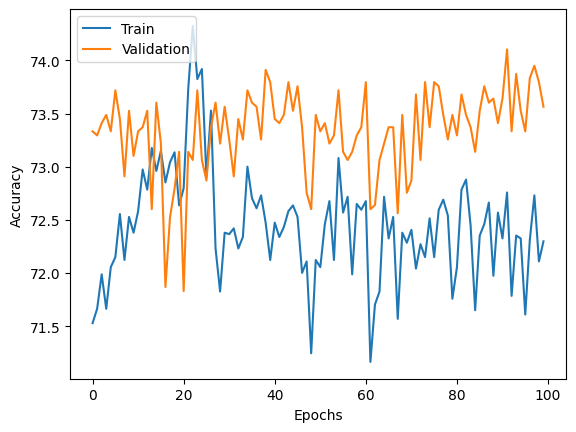

In [20]:
# Plot training and validation accuracy over epochs
plt.plot([i for i in range(len(train_accuracy_list))], train_accuracy_list, label="Train")
plt.plot([i for i in range(len(validation_accuracy_list))], validation_accuracy_list, label="Validation")
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()